In [18]:
%matplotlib inline
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy
import astropy.units as u
import numba as nb
from numba import njit,jit

In [19]:
columns=['name','redshift','distance_mod','DM_err','SN_prob']
rawdat=pd.read_csv('SCPUnion2.1_mu_vs_z.txt', sep='\s',names=columns, header=5, engine='python')

In [20]:
data=np.sort(rawdat.T, axis=0)
zs = rawdat.redshift
mm = rawdat.distance_mod
dm = rawdat.DM_err

In [21]:
from scipy import integrate

In [22]:
#@jit
def DM(z,H0,Om,OL):
    Ok=1-Om-OL
    c = 299792.
    # quad only accepts scalars, so need to use a list comprehension to run through the whole array of zs
    Ezz = lambda zz: 1e6*(c*(1+zz)/H0)*np.sqrt((Om*(1+zz)**3.)+(Ok*(1+zz)**2.)+OL)
    DT = [integrate.cumtrapz(Ezz, zz=range(0,zi)) for zi in z]
    # Returns a list, so we convert to a numpy array
    DL = np.asarray(DT)
    hz = H0 * np.sqrt(Ok* (1 + z)**2 + OL + Om * (1 + z)**3)
    zz = np.linspace(0,1,1000)
    dp = np.zeros(len(z))
    dp[1:] = integrate.cumtrapz(Ezz, zz)
    mag = 5*np.log10(DL[:,0]/10)
    #mag = 5*np.log10(dp[1:]/10)
    return mag

In [23]:

p = lmfit.Parameters()
p.add_many(('Om',0.3,True,0,2),('H0',70,True,50,100),('OL',0.7,True,0,2))
@jit
def residual(p):
    v = p.valuesdict()
    return (DM(zs,v['H0'],v['Om'],v['OL'])-mm)/dm

In [24]:
print p

Parameters([('Om', <Parameter 'Om', 0.3, bounds=[0:2]>), ('H0', <Parameter 'H0', 70, bounds=[50:100]>), ('OL', <Parameter 'OL', 0.7, bounds=[0:2]>)])


In [25]:
%%prun -r
mi = lmfit.minimize(residual, p, method='nelder', nan_policy='omit')

TypeError: range() integer end argument expected, got float.

NameError: name 'mi' is not defined

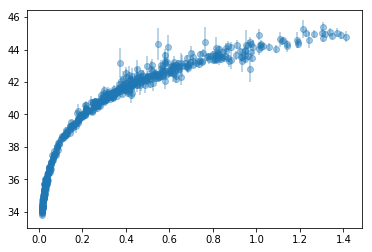

In [17]:
s = (zs.sort_values()).index
plt.errorbar(zs[s],mm[s],yerr=dm[s],fmt='o',alpha=0.4)
bestOm = mi.params.valuesdict()['Om']
bestH0 = mi.params.valuesdict()['H0']
bestOL =mi.params.valuesdict()['OL']
plt.plot(zs[s],DM(zs[s],bestH0,bestOm ,bestOL))
plt.xlabel('Redshift (z)')
plt.ylabel('Distance Modulus (mag)')
lmfit.report_fit(mi)

In [22]:
res = lmfit.minimize(residual, method='emcee', nan_policy='omit', burn=600, steps=5000, thin=1,
                           params=mi.params)

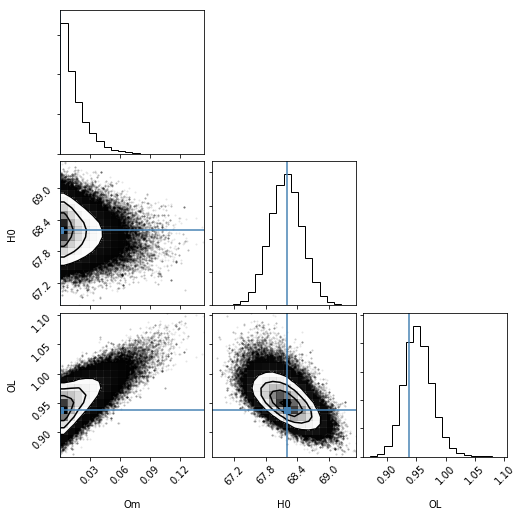

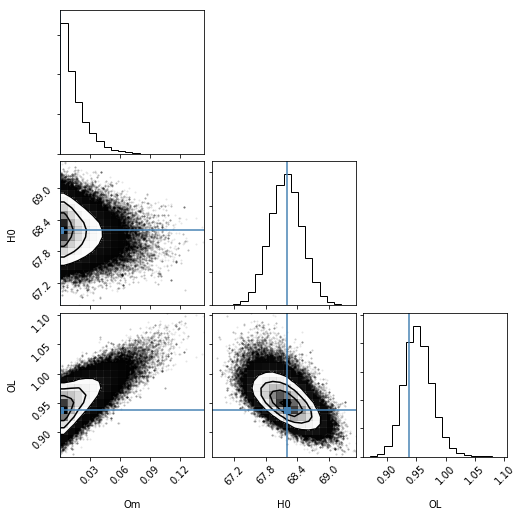

In [23]:
corner.corner(res.flatchain,labels=mi.var_names, truths=list(mi.params.valuesdict().values()))